**Author**: J W Debelius<br/>
**Date**: 27 Feburary 2015<br/>
**Scikit-bio version**: 0.2.2

The goal of this notebook is to compare the order of power loops. Currently, in scikit-bio 0.2.2, power is calculated by generating a paired subsample, and selecting the counts. So, we loop through the runs and then loop through the counts. <br>
I think it will be more robust, and improve speed later, hopefully after optimization.<br>
The new code has already been tested locally, and it passes in both python 2 and python 3. 

I'd also like to try timing the code execution. This is sort of a hacky way to do some intially profiling, but it will give an idea if the switch has signifigantly slowed the code. The idea of timing and profiling comes mostly from [this](https://zapier.com/engineering/profiling-python-boss/) blog post by Bryan Helmig.

This change primarily affects the way `subsample_paired_power` functions. I could generate dummy data, but I'd rather check against real data. So, I'm going to profile AGE in American Gut rounds 1-14 in health adults. I've done a fair bit of work with this as a reference set.

I'm also trying added the possibility of returning multiple p values, with the hope that this can be included in a generalized linear model for time series analysis. I'd like to follow up on timeseries analysis, but I think the code needs to be streamlined, first.

### Relevant System State
* Python 2.7
* Numpy 1.9.1
* Scipy 0.15.1
* Scikit-bio 0.2.2
* Biom 2.1.3
* Matplotlib 1.4.2
* Pandas 0.15.2


In [1]:
# Imports necessary functions
import os
import time
import cProfile

import numpy as np
import pandas as pd
import biom
import skbio
import scipy
import matplotlib.pyplot as plt

from future.utils import viewitems
import skbio.stats.power as power
from americangut.power_plots import collate_effect_size, plot_effects

from statsmodels.stats.power import FTestAnovaPower

ft = FTestAnovaPower()

%matplotlib inline

In [2]:
class timewith():
    def __init__(self, name=''):
        self.name = name
        self.start = time.time()

    @property
    def elapsed(self):
        return time.time() - self.start

    def checkpoint(self, name=''):
        print '{timer} {checkpoint} took {elapsed} seconds'.format(
            timer=self.name,
            checkpoint=name,
            elapsed=self.elapsed,
        ).strip()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.checkpoint('finished')
        pass

We can also define the new subsample funtion.

In [29]:
def subsample_paired_power(test, meta, cat, control_cats, order=None,
                           strict_match=True, alpha_pwr=0.05, ratio=None,
                           min_observations=20, max_counts=50,
                           counts_interval=10, min_counts=None,
                           num_iter=500, num_runs=10):
    r"""Estimates power iteratively using samples with matching metadata"""

    # Checks for the number of sampling pairs avaliable
    sub_ids = paired_subsamples(meta, cat, control_cats, order, strict_match)

    # Determines the minimum number of ids avaliable
    num_ids = len(sub_ids[0])

    # Checks there are enough samples to subsample
    if num_ids <= min_observations:
        raise ValueError('There are not enough samples for subsampling.')

    # Checks the ratio
    num_groups = len(sub_ids)
    if ratio is None:
        ratio = np.ones((num_groups))
    ratio = np.asarray(ratio)
    if not ratio.shape == (num_groups,):
        raise ValueError('There must be a ratio for each group.')

    # Determines the number of p values returned by the test
    p_return = test(sub_ids)
    if isinstance(p_return, float):
        num_p = 1
    elif isinstance(p_return, np.ndarray) and len(p_return.shape) == 1:
        num_p = p_return.shape[0]
    else:
        raise TypeError('test must return a float or one-dimensional array.')

    # Calculates the effect size vector
    if min_counts is None:
        min_counts = counts_interval

    if (max_counts - min_counts) < counts_interval:
        raise ValueError("No subsamples of the specified size can be drawn.")

    sample_counts = np.arange(min_counts,
                              min(max_counts, num_ids),
                              counts_interval)

    # Prealocates the power array
    power = np.zeros((num_runs, len(sample_counts), num_p))

    # Calculates power instances
    for id2, c in enumerate(sample_counts):
        count = np.round(c * ratio, 0).astype(int)
        for id1 in range(num_runs):
            sub_ids = paired_subsamples(meta, cat, control_cats, order,
                                        strict_match)
            ps = _compare_distributions(test=test,
                                        samples=sub_ids,
                                        num_p=num_p,
                                        counts=count,
                                        num_iter=num_iter,
                                        mode="matched")
            power[id1, id2, :] = _calculate_power(ps, alpha_pwr)

    if num_p == 1:
        power = power[:, :, 0]

    return power, sample_counts


def _compare_distributions(test, samples, num_p, counts=5, mode="ind",
                           num_iter=1000):
    r"""Compares two distribution arrays iteratively"""

    # Determines the number of groups
    num_groups = len(samples)

    # Checks the mode
    if mode not in {'ind', 'matched'}:
        raise ValueError('Supported sample modes are "ind" and "matched".')

    # Handles the number of samples for later instances
    if isinstance(counts, int):
        counts = np.array([counts] * num_groups)

    if not len(counts) == num_groups:
        raise ValueError('If counts is a 1-D array, there must be a count to'
                         ' draw for each group.')

    # Checks the group length
    samp_lens = [len(sample) for sample in samples]
    # Checks the group length
    if mode == 'matched' and np.array([samp_lens[i] != samp_lens[i+1] for i in
                                       range(num_groups-1)]).all():
        raise ValueError('In "matched" mode, each sample must have the same'
                         ' number of observations.')
    if np.array([samp_lens[i] < counts[i] for i in range(num_groups)]).any():
        raise ValueError('You cannot choose more observations that exist '
                         'in a sample.')

    # Prealocates the pvalue matrix
    p_values = np.zeros((num_p, num_iter))

    for idx in range(num_iter):
        if mode == "matched":
            pos = np.random.choice(np.arange(0, samp_lens[0]), counts[0],
                                   replace=False)
            subs = [sample[pos] for sample in samples]
        else:
            subs = [np.random.choice(np.array(pop), counts[i], replace=False)
                    for i, pop in enumerate(samples)]

        p_values[:, idx] = test(subs)

    if num_p == 1:
        p_values = np.hstack(p_values)

    return p_values

def _calculate_power(p_values, alpha=0.05):
    r"""Calculates statical power empirically"""

    if len(p_values.shape) == 1:
        p_values = p_values * np.array([[1]])

    w = (p_values < float(alpha)).sum(1)/float(p_values.shape[1])

    return w

def paired_subsamples(meta, cat, control_cats, order=None, strict_match=True):
    r"""Gets a set of samples to serve as controls
    """

    # Sets the index data
    # Groups meta by category
    cat_groups = meta.groupby(cat).groups

    # Handles the order argument
    if order is None:
        order = sorted(cat_groups.keys())
    order = np.array(order)
    num_groups = len(order)

    # Determines the number of samples, and the experimental and control group
    group_size = np.array([len(cat_groups[o]) for o in order])
    ctrl_name = order[group_size == group_size.min()][0]
    order = order[order != ctrl_name]

    # Gets a control group table
    ctrl_match_groups = meta.groupby(control_cats).groups
    ctrl_group = meta.loc[cat_groups[ctrl_name]
                          ].groupby(list(control_cats)).groups

    ids = [np.array([])] * num_groups
    # Loops through samples in the experimental group to match for controls
    for check_group, ctrl_ids in viewitems(ctrl_group):
        # Checks the categories have been defined
        undefed_check = np.array([_check_strs(p) for p in check_group])
        if not undefed_check.all() and strict_match:
            continue
        # Removes the matched ids from order
        matched_ids = ctrl_match_groups[check_group]
        for id_ in ctrl_ids:
            matched_ids.remove(id_)
        pos_ids = []
        num_ids = [len(ctrl_ids)]
        # Gets the matrix of the matched ids and groups them
        exp_group = meta.loc[matched_ids].groupby(cat).groups
        for grp in order:
            # Checks group to be considered is included in the grouping
            if grp not in exp_group:
                break
            # Gets the id associated with the group
            pos_ids.append(exp_group[grp])
            num_ids.append(len(exp_group[grp]))
        # Determines the minimum number of samples
        num_draw = np.array(num_ids).min()
        # Draws samples from possible ids
        exp_ids = [np.random.choice(ctrl_ids, num_draw, replace=False)]
        exp_ids.extend([np.random.choice(id_, num_draw, replace=False)
                        for id_ in pos_ids])

        if len(exp_ids) == num_groups:
            for idx in range(num_groups):
                ids[idx] = np.hstack((ids[idx], exp_ids[idx]))

    return ids

def _check_strs(x):
    r"""Returns False if x is a nan and True is x is a string or number"""

    if isinstance(x, str):
        return True
    elif isinstance(x, (float, int)):
        return not np.isnan(x)
    else:
        raise TypeError('input must be a string, float or a nan')


Now, we'll import the American Gut data. This has been saved in the data directory.

In [4]:
base_dir = os.path.abspath('../..')
data_dir = os.path.join(base_dir, 'data/ag_fecal_one_sample_sub')

otu_ = biom.load_table(os.path.join(data_dir, 'AGP_100nt_even10k_fecal.biom'))
map_ = pd.read_csv(os.path.join(data_dir, 'AGP_100nt_even10k_fecal.txt'),
                   sep='\t',
                   index_col=None)
map_.index = map_['#SampleID']

Now, I'd like to define the test function. We'll test that there's a difference in alpha diversity between the two groups.

In [5]:
def test_alpha(x):
    vals = [map_.loc[i, 'PD_whole_tree_mean'].values for i in x]
    return scipy.stats.kruskal(*vals)[1]

In [6]:
# Times the old skbio functions
timer = timewith('old_sampling_age')
pwr_age_220, cnts_age_220 = skbio.stats.power.subsample_paired_power(test_alpha,
                                                                     map_,
                                                                     'AGE_CAT',
                                                                     ['TYPES_OF_PLANTS', 'ALCOHOL_FREQUENCY',
                                                                      'COLLECTION_SEASON', 'SLEEP_DURATION'],
                                                                     ['20s', '60s'],
                                                                     num_iter=500,
                                                                     counts_interval=2,
                                                                     max_counts=25)
timer.checkpoint('done_age')
timer = timewith('new_sampling_age')
pwr_age_new, cnts_age_new = subsample_paired_power(test_alpha,
                                                   map_,
                                                   'AGE_CAT',
                                                   ['TYPES_OF_PLANTS', 'ALCOHOL_FREQUENCY',
                                                    'COLLECTION_SEASON', 'SLEEP_DURATION'],
                                                   ['20s', '60s'],
                                                   num_iter=500,
                                                   counts_interval=2,
                                                   max_counts=25)
timer.checkpoint('done_age')

old_sampling_age done_age took 51.16091609 seconds
new_sampling_age done_age took 54.0248610973 seconds


In [7]:
timer = timewith('old_sampling_EtOH')
pwr_etoh_220, cnts_etoh_220 = skbio.stats.power.subsample_paired_power(test_alpha,
                                                                     map_,
                                                                     'ALCOHOL_FREQUENCY',
                                                                     ['AGE_CAT', 'TYPES_OF_PLANTS', 'COLLECTION_SEASON', 'SLEEP_DURATION'],
                                                                     ['Never', 'Daily'],
                                                                     num_iter=500,
                                                                     counts_interval=2,
                                                                     min_observations=15,
                                                                     max_counts=16)
timer.checkpoint('done_EtOH')
timer = timewith('new_sampling_EtOH')
pwr_etoh_new, cnts_etoh_new = subsample_paired_power(test_alpha,
                                                     map_,
                                                     'ALCOHOL_FREQUENCY',
                                                     ['AGE_CAT', 'TYPES_OF_PLANTS', 'COLLECTION_SEASON', 'SLEEP_DURATION'],
                                                     ['Never', 'Daily'],
                                                     num_iter=500,
                                                     counts_interval=2,
                                                     min_observations=15,
                                                     max_counts=16)
timer.checkpoint('done_EtOH')

old_sampling_EtOH done_EtOH took 34.7270410061 seconds
new_sampling_EtOH done_EtOH took 36.4641721249 seconds


In [8]:
timer = timewith('old_sampling_season')
pwr_season_220, cnts_season_220 = skbio.stats.power.subsample_paired_power(test_alpha,
                                                                     map_,
                                                                     'COLLECTION_SEASON',
                                                                     ['AGE_CAT', 'ALCOHOL_FREQUENCY', 'TYPES_OF_PLANTS', 'SLEEP_DURATION'],
                                                                     ['Winter', 'Summer'],
                                                                     num_iter=500,
                                                                     counts_interval=2,
                                                                     max_counts=22)
timer.checkpoint('done_season')
timer = timewith('new_sampling_season')
pwr_season_new, cnts_season_new = subsample_paired_power(test_alpha,
                                                        map_,
                                                        'COLLECTION_SEASON',
                                                        ['AGE_CAT', 'ALCOHOL_FREQUENCY', 'TYPES_OF_PLANTS', 'SLEEP_DURATION'],
                                                        ['Winter', 'Summer'],
                                                        num_iter=500,
                                                        counts_interval=2,
                                                        max_counts=22)
timer.checkpoint('done_season')

old_sampling_season done_season took 48.9305009842 seconds
new_sampling_season done_season took 55.2347548008 seconds


So, I think the switch is more expensive, and kind of a pain-in-the ass for running big sets of data. But, I also think it will allow more robust sampling. Because, theoretically, we'll be able ot determine how many runs and counts are necessary. Or, at least, that's the goal.

More importantly, I'd like to see if the change ultimately changed the results.

In [9]:
# Collates the power for age
age_mean, age_bounds = collate_effect_size([cnts_age_220, cnts_age_new], [pwr_age_220, pwr_age_new], 0.05)
etoh_mean, etoh_bounds = collate_effect_size([cnts_etoh_220, cnts_etoh_new], [pwr_etoh_220, pwr_etoh_new], 0.05)
season_mean, season_bounds = collate_effect_size([cnts_season_220, cnts_season_new], [pwr_season_220, pwr_season_new], 0.05)

In [10]:
# Calculates lower and upper bounds
counts = np.arange(5, 305, 5)
etoh_220_mean = np.array([ft.solve_power(effect_size=etoh_mean[0], nobs=c, alpha=0.05) for c in counts])
etoh_220_lower = np.array([ft.solve_power(effect_size=etoh_mean[0] - etoh_bounds[0], nobs=c, alpha=0.05) for c in counts])
etoh_220_upper = np.array([ft.solve_power(effect_size=etoh_mean[0] + etoh_bounds[0], nobs=c, alpha=0.05) for c in counts])
etoh_new_mean = np.array([ft.solve_power(effect_size=etoh_mean[1], nobs=c, alpha=0.05) for c in counts])
etoh_new_lower = np.array([ft.solve_power(effect_size=etoh_mean[1] - etoh_bounds[1], nobs=c, alpha=0.05) for c in counts])
etoh_new_upper = np.array([ft.solve_power(effect_size=etoh_mean[1] + etoh_bounds[1], nobs=c, alpha=0.05) for c in counts])

season_220_mean = np.array([ft.solve_power(effect_size=season_mean[0], nobs=c, alpha=0.05) for c in counts])
season_220_lower = np.array([ft.solve_power(effect_size=season_mean[0] - season_bounds[0], nobs=c, alpha=0.05) for c in counts])
season_220_upper = np.array([ft.solve_power(effect_size=season_mean[0] + season_bounds[0], nobs=c, alpha=0.05) for c in counts])
season_new_mean = np.array([ft.solve_power(effect_size=season_mean[1], nobs=c, alpha=0.05) for c in counts])
season_new_lower = np.array([ft.solve_power(effect_size=season_mean[1] - season_bounds[1], nobs=c, alpha=0.05) for c in counts])
season_new_upper = np.array([ft.solve_power(effect_size=season_mean[1] + season_bounds[1], nobs=c, alpha=0.05) for c in counts])

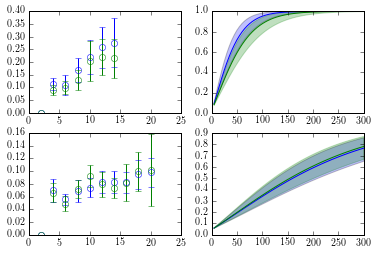

In [11]:
# Creates a bunch of subplot
ax1a = plt.subplot(2, 2, 1)
ax1b = plt.subplot(2, 2, 2)
ax2a = plt.subplot(2, 2, 3)
ax2b = plt.subplot(2, 2, 4)

# Plots the mean traces with error bars
ax1a.errorbar(cnts_etoh_220, pwr_etoh_220.mean(0), yerr=pwr_etoh_220.std(0), marker='o', linestyle='none', mfc='none', mec='b')
ax1a.errorbar(cnts_etoh_new, pwr_etoh_new.mean(0), yerr=pwr_etoh_new.std(0), marker='o', linestyle='none', mfc='none', mec='g')
ax2a.errorbar(cnts_season_220, pwr_season_220.mean(0), yerr=pwr_season_220.std(0), marker='o', linestyle='none', mfc='none', mec='b')
ax2a.errorbar(cnts_season_220, pwr_season_new.mean(0), yerr=pwr_season_new.std(0), marker='o', linestyle='none', mfc='none', mec='g')

ax1a.set_xlim([0, 25])
ax2a.set_xlim([0, 25])



ax2b.fill_between(counts, season_220_lower, season_220_upper, alpha=0.25)
ax2b.fill_between(counts, season_new_lower, season_new_upper, alpha=0.25, color='g')
ax2b.plot(counts, season_220_mean, 'b')
ax2b.plot(counts, season_new_mean, 'g')

**Added 22 March 2015**
I'd alost like to test the overlap between two runs of the old code.

In [12]:
pwr_etoh_22a, cnts_etoh_22a = skbio.stats.power.subsample_paired_power(test_alpha,
                                                                     map_,
                                                                     'ALCOHOL_FREQUENCY',
                                                                     ['AGE_CAT', 'TYPES_OF_PLANTS', 'COLLECTION_SEASON', 'SLEEP_DURATION'],
                                                                     ['Never', 'Daily'],
                                                                     num_iter=500,
                                                                     counts_interval=2,
                                                                     min_observations=15,
                                                                     max_counts=16)

In [14]:
etoh_mean2, etoh_bounds2 = collate_effect_size([cnts_etoh_22a, cnts_etoh_220], [pwr_etoh_220, pwr_etoh_220], 0.05)

etoh_22a_mean = np.array([ft.solve_power(effect_size=etoh_mean2[0], nobs=c, alpha=0.05) for c in counts])
etoh_22a_lower = np.array([ft.solve_power(effect_size=etoh_mean2[0] - etoh_bounds2[0], nobs=c, alpha=0.05) for c in counts])
etoh_22a_upper = np.array([ft.solve_power(effect_size=etoh_mean2[0] + etoh_bounds2[0], nobs=c, alpha=0.05) for c in counts])
etoh_220_mean = np.array([ft.solve_power(effect_size=etoh_mean2[1], nobs=c, alpha=0.05) for c in counts])
etoh_220_lower = np.array([ft.solve_power(effect_size=etoh_mean2[1] - etoh_bounds2[1], nobs=c, alpha=0.05) for c in counts])
etoh_200_upper = np.array([ft.solve_power(effect_size=etoh_mean2[1] + etoh_bounds2[1], nobs=c, alpha=0.05) for c in counts])

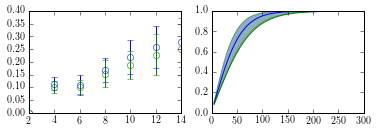

In [17]:
# Creates a bunch of subplot
ax1a = plt.subplot(2, 2, 1)
ax1b = plt.subplot(2, 2, 2)

# Plots the mean traces with error bars
ax1a.errorbar(cnts_etoh_220, pwr_etoh_220.mean(0), yerr=pwr_etoh_220.std(0), marker='o', linestyle='none', mfc='none', mec='b')
ax1a.errorbar(cnts_etoh_new, pwr_etoh_22a.mean(0), yerr=pwr_etoh_22a.std(0), marker='o', linestyle='none', mfc='none', mec='g')

ax1b.fill_between(counts, etoh_220_lower, etoh_220_upper, alpha=0.25)
ax1b.fill_between(counts, etoh_22a_lower, etoh_22a_upper, alpha=0.25, color='g')
ax1b.plot(counts, etoh_220_mean, 'b')
ax1b.plot(counts, etoh_new_mean, 'g')

Based on these examples, there is a relatively consistent overlap between the values calculated by running the code in either order.

...Okay, because I'd like to improve the run time on the new code, I'd like to profile both sets of code. Again, HT to the ["Profiling Python like a Boss"](https://zapier.com/engineering/profiling-python-boss/) blog post.

In [18]:
import cProfile

def do_cprofile(func):
    def profiled_func(*args, **kwargs):
        profile = cProfile.Profile()
        try:
            profile.enable()
            result = func(*args, **kwargs)
            profile.disable()
            return result
        finally:
            profile.print_stats()
    return profiled_func

In [19]:
@do_cprofile
def calc_old_etoh_pwr():
    pwr_etoh_220, cnts_etoh_220 = skbio.stats.power.subsample_paired_power(test_alpha,
                                                                     map_,
                                                                     'ALCOHOL_FREQUENCY',
                                                                     ['AGE_CAT', 'TYPES_OF_PLANTS', 'COLLECTION_SEASON', 'SLEEP_DURATION'],
                                                                     ['Never', 'Daily'],
                                                                     num_iter=500,
                                                                     counts_interval=2,
                                                                     min_observations=15,
                                                                     max_counts=16)
    return 'Etanol Power!'
results_old = calc_old_etoh_pwr()

         35953849 function calls (35595389 primitive calls) in 45.195 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   45.195   45.195 <ipython-input-19-93145e9ea0b7>:1(calc_old_etoh_pwr)
    35000    0.519    0.000   42.843    0.001 <ipython-input-5-640c322d58e3>:1(test_alpha)
   283330    0.213    0.000    0.337    0.000 __init__.py:121(iteritems)
       10    0.000    0.000    0.000    0.000 __init__.py:247(viewitems)
      820    0.001    0.000    0.006    0.000 _methods.py:28(_amin)
   105070    0.058    0.000    0.609    0.000 _methods.py:31(_sum)
    36130    0.024    0.000    0.230    0.000 _methods.py:34(_prod)
    73240    0.055    0.000    0.559    0.000 _methods.py:37(_any)
      900    0.001    0.000    0.006    0.000 _methods.py:40(_all)
       80    0.000    0.000    0.001    0.000 algorithms.py:402(_get_data_algo)
       80    0.002    0.000    0.007    0.000 algorithms.py:98(fac

In [20]:
@do_cprofile
def calc_new_etoh_pwr():
    pwr_etoh_220, cnts_etoh_220 = subsample_paired_power(test_alpha,
                                                         map_,
                                                         'ALCOHOL_FREQUENCY',
                                                         ['AGE_CAT', 'TYPES_OF_PLANTS', 'COLLECTION_SEASON', 'SLEEP_DURATION'],
                                                         ['Never', 'Daily'],
                                                         num_iter=500,
                                                         counts_interval=2,
                                                         min_observations=15,
                                                         max_counts=16)
    return 'Etanol Power!'
results_new = calc_new_etoh_pwr()

         39462702 function calls (39052626 primitive calls) in 55.278 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   55.278   55.278 <ipython-input-20-29179cc64850>:1(calc_new_etoh_pwr)
        1    0.009    0.009   55.278   55.278 <ipython-input-3-ea3fa562006d>:1(subsample_paired_power)
       70    0.002    0.000    0.003    0.000 <ipython-input-3-ea3fa562006d>:118(_calculate_power)
       71    0.204    0.003    6.543    0.092 <ipython-input-3-ea3fa562006d>:128(paired_subsamples)
    23572    0.011    0.000    0.014    0.000 <ipython-input-3-ea3fa562006d>:187(_check_strs)
       70    0.382    0.005   48.722    0.696 <ipython-input-3-ea3fa562006d>:69(_compare_distributions)
    35001    0.593    0.000   47.174    0.001 <ipython-input-5-640c322d58e3>:1(test_alpha)
   303651    0.250    0.000    0.427    0.000 __init__.py:121(iteritems)
       71    0.000    0.000    0.000    0.000 __init__.p

So, for some reason, I find this output entirely uninteligable. I can try the line profiler, which will be substantially slower than the results I see here, but will probably better indicate where I'm having an issue, and how it can be solved.

In [21]:
from line_profiler import LineProfiler

In [22]:
try:
    from line_profiler import LineProfiler

    def do_profile(follow=[]):
        def inner(func):
            def profiled_func(*args, **kwargs):
                try:
                    profiler = LineProfiler()
                    profiler.add_function(func)
                    for f in follow:
                        profiler.add_function(f)
                    profiler.enable_by_count()
                    return func(*args, **kwargs)
                finally:
                    profiler.print_stats()
            return profiled_func
        return inner

except ImportError:
    def do_profile():
        "Helpful if you accidentally leave in production!"
        def inner(func):
            def nothing(*args, **kwargs):
                return func(*args, **kwargs)
            return nothing
        return inner

In [26]:
@do_profile(follow=[skbio.stats.power._compare_distributions, skbio.stats.power.paired_subsamples, skbio.stats.power._check_strs, skbio.stats.power.subsample_paired_power, skbio.stats.power._calculate_power])
def calc_new_etoh_pwr():
    pwr_etoh_220, cnts_etoh_220 = skbio.stats.power.subsample_paired_power(test_alpha,
                                                                           map_,
                                                                           'ALCOHOL_FREQUENCY',
                                                                           ['AGE_CAT', 'TYPES_OF_PLANTS', 'COLLECTION_SEASON', 'SLEEP_DURATION'],
                                                                           ['Never', 'Daily'],
                                                                           num_iter=500,
                                                                           counts_interval=2,
                                                                           min_observations=15,
                                                                           max_counts=16)
results = calc_new_etoh_pwr()

Timer unit: 1e-06 s

Total time: 64.1193 s
File: /Users/jwdebelius/.virtualenvs/playground/lib/python2.7/site-packages/skbio/stats/power.py
Function: subsample_paired_power at line 328

Line #      Hits         Time  Per Hit   % Time  Line Contents
   328                                           def subsample_paired_power(test, meta, cat, control_cats, order=None,
   329                                                                      strict_match=True, alpha_pwr=0.05,
   330                                                                      min_observations=20, max_counts=50,
   331                                                                      counts_interval=10, min_counts=None,
   332                                                                      num_iter=500, num_runs=10):
   333                                               r"""Estimates power iteratively using samples with matching metadata
   334                                           
   335              

In [30]:
@do_profile(follow=[_compare_distributions, paired_subsamples, subsample_paired_power, _calculate_power])
def calc_new_etoh_pwr():
    pwr_etoh_220, cnts_etoh_220 = subsample_paired_power(test_alpha,
                                                         map_,
                                                         'ALCOHOL_FREQUENCY',
                                                         ['AGE_CAT', 'TYPES_OF_PLANTS', 'COLLECTION_SEASON', 'SLEEP_DURATION'],
                                                         ['Never', 'Daily'],
                                                         num_iter=500,
                                                         counts_interval=2,
                                                         min_observations=15,
                                                         max_counts=16)
results = calc_new_etoh_pwr()

Timer unit: 1e-06 s

Total time: 62.1717 s
File: <ipython-input-29-ea3fa562006d>
Function: subsample_paired_power at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def subsample_paired_power(test, meta, cat, control_cats, order=None,
     2                                                                      strict_match=True, alpha_pwr=0.05, ratio=None,
     3                                                                      min_observations=20, max_counts=50,
     4                                                                      counts_interval=10, min_counts=None,
     5                                                                      num_iter=500, num_runs=10):
     6                                               r"""Estimates power iteratively using samples with matching metadata"""
     7                                           
     8                                               # Checks for 

Based on what I'm reading, the expensive step is the test function (which I can't really make that much faster) and grouping my data in pandas (which I again, can't really make faster). So, I think if I parallelize... or Josh parallelizes the test function, it would make it faster. We cna try that here.

In [24]:
from multiprocessing import Pool

def subsample_paired_power_pool(test, meta, cat, control_cats, order=None,
                                strict_match=True, alpha_pwr=0.05, ratio=None,
                                min_observations=20, max_counts=50,
                                counts_interval=10, min_counts=None,
                                num_iter=500, num_runs=10, num_cpus=1):
    r"""Estimates power iteratively using samples with matching metadata"""

    # Checks for the number of sampling pairs avaliable
    sub_ids = paired_subsamples(meta, cat, control_cats, order, strict_match)

    # Determines the minimum number of ids avaliable
    num_ids = len(sub_ids[0])

    # Checks there are enough samples to subsample
    if num_ids <= min_observations:
        raise ValueError('There are not enough samples for subsampling.')

    # Checks the ratio
    num_groups = len(sub_ids)
    if ratio is None:
        ratio = np.ones((num_groups))
    ratio = np.asarray(ratio)
    if not ratio.shape == (num_groups,):
        raise ValueError('There must be a ratio for each group.')

    # Determines the number of p values returned by the test
    p_return = test(sub_ids)
    if isinstance(p_return, float):
        num_p = 1
    elif isinstance(p_return, np.ndarray) and len(p_return.shape) == 1:
        num_p = p_return.shape[0]
    else:
        raise TypeError('test must return a float or one-dimensional array.')

    # Calculates the effect size vector
    if min_counts is None:
        min_counts = counts_interval

    if (max_counts - min_counts) < counts_interval:
        raise ValueError("No subsamples of the specified size can be drawn.")

    sample_counts = np.arange(min_counts,
                              min(max_counts, num_ids),
                              counts_interval)

    # Prealocates the power array
    power = np.zeros((num_runs, len(sample_counts), num_p))

    # Calculates power instances
    # We're going to attempt multithreading to speed this up. So, we'll make a pool object
    for id2, c in enumerate(sample_counts):
        count = np.round(c * ratio, 0).astype(int)
        for id1 in range(num_runs):
            sub_ids = paired_subsamples(meta, cat, control_cats, order,
                                        strict_match)
            ps = _compare_distributions_pool(test=test,
                                             samples=sub_ids,
                                             num_p=num_p,
                                             counts=count,
                                             num_iter=num_iter,
                                             mode="matched",
                                             num_cpus=num_cpus)
            power[id1, id2, :] = _calculate_power(ps, alpha_pwr)

    if num_p == 1:
        power = power[:, :, 0]

    return power, sample_counts

def _compare_distributions_pool(test, samples, num_p, counts=5, mode="ind",
                                num_iter=1000, num_cpus=1):
    r"""Compares two distribution arrays iteratively"""

    # Determines the number of groups
    num_groups = len(samples)

#     # Checks the mode
#     if mode not in {'ind', 'matched'}:
#         raise ValueError('Supported sample modes are "ind" and "matched".')

    # Handles the number of samples for later instances
    if isinstance(counts, int):
        counts = np.array([counts] * num_groups)

#     if not len(counts) == num_groups:
#         raise ValueError('If counts is a 1-D array, there must be a count to'
#                          ' draw for each group.')

    # Checks the group length
    samp_lens = [len(sample) for sample in samples]
#     # Checks the group length
#     if mode == 'matched' and np.array([samp_lens[i] != samp_lens[i+1] for i in
#                                        range(num_groups-1)]).all():
#         raise ValueError('In "matched" mode, each sample must have the same'
#                          ' number of observations.')
#     if np.array([samp_lens[i] < counts[i] for i in range(num_groups)]).any():
#         raise ValueError('You cannot choose more observations that exist '
#                          'in a sample.')

    # Prealocates the pvalue matrix
    p_values = []

    swimmingly = Pool(num_cpus)
    for idx in range(num_iter):
        if mode == "matched":
            pos = np.random.choice(np.arange(0, samp_lens[0]), counts[0],
                                   replace=False)
            subs = [sample[pos] for sample in samples]
        else:
            subs = [np.random.choice(np.array(pop), counts[i], replace=False)
                    for i, pop in enumerate(samples)]

        swimmingly.apply_async(test, [subs], callback=p_values.append)
    
    swimmingly.close()
    swimmingly.join()
    
    p_values = np.asarray(p_values)

    if num_p == 1:
        p_values = np.hstack(p_values)

    return p_values

In [ ]:
@do_profile(follow=[power._compare_distributions, power.paired_subsamples, power._check_strs, power.subsample_paired_power_pool])
def calc_new_etoh_pwr_pool():
    pwr_etoh_220, cnts_etoh_220 = subsample_paired_power_pool(test_alpha,
                                                              map_,
                                                             'ALCOHOL_FREQUENCY',
                                                             ['AGE_CAT', 'TYPES_OF_PLANTS', 'COLLECTION_SEASON', 'SLEEP_DURATION'],
                                                             ['Never', 'Daily'],
                                                             num_iter=500,
                                                             counts_interval=2,
                                                             min_observations=15,
                                                             max_counts=16,
                                                             num_cpus=4)
results = calc_new_etoh_pwr_pool()

In [23]:
@do_profile(follow=[_compare_distributions_pool, paired_subsamples, _check_strs, subsample_paired_power_pool])
def calc_new_etoh_pwr_pool():
    pwr_etoh_220, cnts_etoh_220 = subsample_paired_power_pool(test_alpha,
                                                              map_,
                                                             'ALCOHOL_FREQUENCY',
                                                             ['AGE_CAT', 'TYPES_OF_PLANTS', 'COLLECTION_SEASON', 'SLEEP_DURATION'],
                                                             ['Never', 'Daily'],
                                                             num_iter=500,
                                                             counts_interval=2,
                                                             min_observations=15,
                                                             max_counts=16,
                                                             num_cpus=4)
results = calc_new_etoh_pwr_pool()

Timer unit: 1e-06 s

Total time: 33.1467 s
File: <ipython-input-22-4c7d0132ab82>
Function: subsample_paired_power_pool at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def subsample_paired_power_pool(test, meta, cat, control_cats, order=None,
     4                                                                           strict_match=True, alpha_pwr=0.05, ratio=None,
     5                                                                           min_observations=20, max_counts=50,
     6                                                                           counts_interval=10, min_counts=None,
     7                                                                           num_iter=500, num_runs=10, num_cpus=1):
     8                                               r"""Estimates power iteratively using samples with matching metadata"""
     9                                           
    10                  

In [25]:
# I removed some error checks from _compare_distributions_pool to see what happens, and if theres an improvement.

@do_profile(follow=[_compare_distributions_pool, paired_subsamples, _check_strs, subsample_paired_power_pool])
def calc_new_etoh_pwr_pool():
    pwr_etoh_220, cnts_etoh_220 = subsample_paired_power_pool(test_alpha,
                                                              map_,
                                                             'ALCOHOL_FREQUENCY',
                                                             ['AGE_CAT', 'TYPES_OF_PLANTS', 'COLLECTION_SEASON', 'SLEEP_DURATION'],
                                                             ['Never', 'Daily'],
                                                             num_iter=500,
                                                             counts_interval=2,
                                                             min_observations=15,
                                                             max_counts=16,
                                                             num_cpus=4)
results = calc_new_etoh_pwr_pool()

Timer unit: 1e-06 s

Total time: 32.4868 s
File: <ipython-input-24-254036a3f1df>
Function: subsample_paired_power_pool at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def subsample_paired_power_pool(test, meta, cat, control_cats, order=None,
     4                                                                           strict_match=True, alpha_pwr=0.05, ratio=None,
     5                                                                           min_observations=20, max_counts=50,
     6                                                                           counts_interval=10, min_counts=None,
     7                                                                           num_iter=500, num_runs=10, num_cpus=1):
     8                                               r"""Estimates power iteratively using samples with matching metadata"""
     9                                           
    10                  

Removing the error checks doesn't create an appreciable improvement in the running time. But, I can cut hte run time in half with the multi-processing. I'm going to move this into testing.